# Task 1 - State‑Vector Quantum Computer Simulator

## Task 1.1 - State‑vector representation

In [1]:
# @title
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
assert np.isclose(np.linalg.norm(psi), 1.0)

We use the computational basis ordered as ∣00⟩,∣01⟩,∣10⟩,∣11⟩
mapping a bitstring 𝑏1, 𝑏2 to the integer index (2x𝑏1+𝑏2)), such that integer index of ∣00⟩ = 0, ∣01⟩ = 1, ∣10⟩ = 2, ∣11⟩ = 3.

## Task 1.2 - Quantum gate implementation

In [2]:
# @title
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2)
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

The control and target convention for CNOT above is control = q0 (MSB), target = q1 (LSB), respectively. The basis is ordered as {∣00⟩,∣01⟩,∣10⟩,∣11⟩} with q0 as the MSB and q1 as the LSB. CNOT leaves the first two states (𝑞0=0) unchanged and swaps the last two (𝑞0=1), which exactly means “control on 𝑞0, flip target 𝑞1.

## Task 1.3 - Circuit simulation: Bell state

In [3]:
# @title
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]


The output shows amplitudes of 0.707107 (5 s.f.)=~1/√2 for ∣00⟩ and ∣11⟩, with zero amplitude for ∣01⟩ and ∣10⟩. In words, this means the final state is an equal superposition of ∣00⟩ and ∣11⟩, which is exactly the expected result of the Bell state vector.

## Task 1.4 - Output, verification, and circle‑plot comparison

{'00': 4983, '01': 0, '10': 0, '11': 5017}


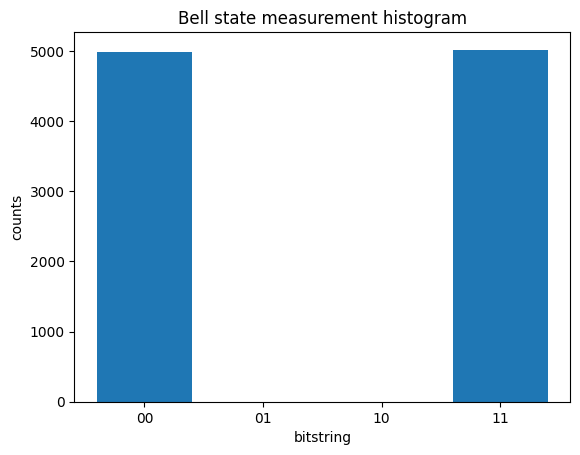

In [4]:
# @title
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

The Bell state has equal probability amplitudes for ∣00⟩ and ∣11⟩, ∣0.707∣^2=0.5. Considering the sampling probability, the results correspond to this probability, where the number of ∣00⟩ = 4983, similar to the number of ∣11⟩ = 5017, represened by almost equal bars in the histogram.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00


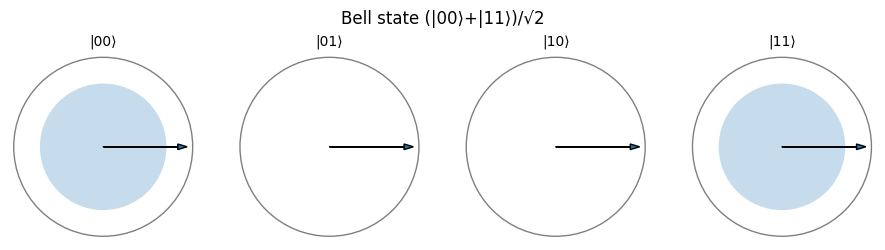

In [5]:
!pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

def statevector_from_aer(circ: QuantumCircuit) -> np.ndarray:
    backend = Aer.get_backend("aer_simulator_statevector")
    tqc = transpile(circ, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.get_statevector(tqc), dtype=np.complex128)

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

qc = QuantumCircuit(2, name="Bell")
qc.h(0)
qc.cx(0, 1)
qc.save_statevector()     # Save state vector after all gates have been applied

sv = statevector_from_aer(qc)
QubitSystem(sv, label="Bell state (|00⟩+|11⟩)/√2").viz_circle()

The circle plot shows two dominant components ∣00⟩ and ∣11⟩ via the shaded regions (nonzero probability), while ∣01⟩ and ∣10⟩ have zero probability. Their relative phase is indicated by the arrows (here both pointing right, so same phase).

# Task 2 - State‑Vector SWAP Test

In [6]:
import numpy as np

# numeric dtype
DTYPE = np.complex128

# Hadamard gate
H = (1/np.sqrt(2)) * np.array([[1, 1],
                               [1, -1]], dtype=DTYPE)

# helper: Kronecker product of a list of matrices
def kron_all(mats):
    out = mats[0]
    for m in mats[1:]:
        out = np.kron(out, m)
    return out

def expand_1q_n(U, t, n):
    """
    Expand a 1-qubit unitary U to act on target qubit t in an n-qubit system.
    Qubit ordering: [0,...,n-1] with 0 = leftmost (most significant).
    """
    ops = []
    for i in range(n):
        if i == t:
            ops.append(U)
        else:
            ops.append(np.eye(2, dtype=DTYPE))
    return kron_all(ops)

# Build CSWAP (8x8)
# CSWAP = |0><0| ⊗ I_4 + |1><1| ⊗ SWAP_2
P0 = np.array([[1,0],[0,0]], dtype=DTYPE)
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)

SWAP_2 = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
], dtype=DTYPE)

CSWAP = np.kron(P0, np.eye(4, dtype=DTYPE)) + np.kron(P1, SWAP_2)

def swap_test(psi: np.ndarray, phi: np.ndarray):
    psi = psi / np.linalg.norm(psi)
    phi = phi / np.linalg.norm(phi)

    # initial state |0>⊗|ψ>⊗|φ>
    init = np.kron(np.array([1,0], dtype=DTYPE), np.kron(psi, phi))

    # H on ancilla
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    # CSWAP
    state = CSWAP @ state
    # final H on ancilla
    state = U_Ho @ state

    probs = np.abs(state)**2
    prob_1 = probs[4:].sum()   # ancilla=1 indices (MSB-first ordering)

    F_hat = 1 - 2*prob_1
    F_exact = float(np.abs(np.vdot(psi, phi))**2)

    return prob_1, F_hat, F_exact

# Define common states
zero = np.array([1,0], dtype=DTYPE)
one  = np.array([0,1], dtype=DTYPE)
plus = (1/np.sqrt(2)) * np.array([1,1], dtype=DTYPE)

# Run tests
tests = [
    ("|ψ⟩=|φ⟩=|0⟩", zero, zero),
    ("|ψ⟩=|0⟩, |φ⟩=|1⟩", zero, one),
    ("|ψ⟩=|+⟩, |φ⟩=|0⟩", plus, zero),
]

for label, psi, phi in tests:
    prob_1, F_hat, F_exact = swap_test(psi, phi)
    print(f"{label} ⇒ F_exact={F_exact:.3f}, F_hat={F_hat:.3f}, P(output=1)={prob_1:.3f}")

|ψ⟩=|φ⟩=|0⟩ ⇒ F_exact=1.000, F_hat=1.000, P(output=1)=0.000
|ψ⟩=|0⟩, |φ⟩=|1⟩ ⇒ F_exact=0.000, F_hat=0.000, P(output=1)=0.500
|ψ⟩=|+⟩, |φ⟩=|0⟩ ⇒ F_exact=0.500, F_hat=0.500, P(output=1)=0.250


The exact fidelity is computed directly from the inner product of the two states, while the swap test estimate is inferred from measurement outcomes on the ancilla qubit.

Since
|0> vs |0> → 𝐹hat≈1.000, 𝐹exact=1.000, (perfect overlap) </br>
|0> vs |1> → 𝐹hat≈0.000, 𝐹exact=0.000, (orthogonal, no overlap) </br>
|0> vs |+> → 𝐹hat≈0.500, 𝐹exact=0.500, (half overlap)

the ancilla’s output distribution provides an operational way to estimate fidelity without having to compute the inner product directly.

Furthermore, the smaller the probability of measuring 1 on the ancilla (output bit), the larger the fidelity between the two states.

# Bonus Exercise - Quantum State Comparison with the Multiqubit SWAP Test

## Task B.1 - Basis vs |5>: design, simulate, evaluate


Test state bits: 011
For 1000 shots
P(output=1): 0.512
Counts: {'0': 512, '1': 488}
Estimated fidelity: 0.024
For 2000 shots
P(output=1): 0.4835
Counts: {'1': 1033, '0': 967}
Estimated fidelity: -0.033
For 4000 shots
P(output=1): 0.503
Counts: {'0': 2012, '1': 1988}
Estimated fidelity: 0.006


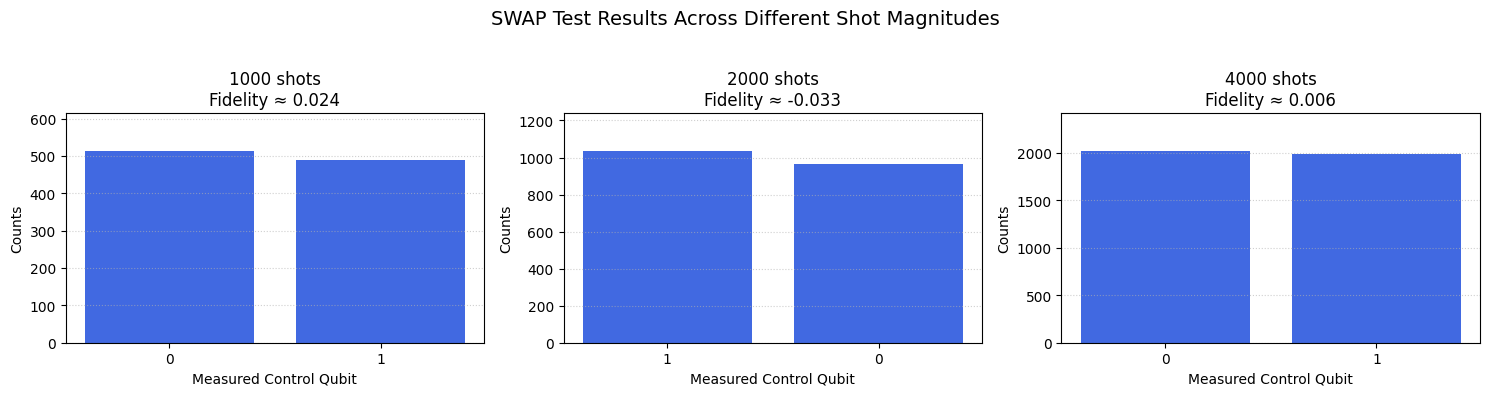


Running positive (same) trials...
Running negative (different) trials...
Running uniform superposition trials...

Shots | mean F (pos) ± stderr | mean F (neg) ± stderr
 1000 | 0.013600 ± 0.003134 | 0.013600 ± 0.003134
 2000 | 0.008367 ± 0.003311 | 0.008367 ± 0.003311
 4000 | 0.005067 ± 0.001880 | 0.005067 ± 0.001880

Shots | mean F (uniform) ± stderr
 1000 | 1.000000 ± 0.000000
 2000 | 1.000000 ± 0.000000
 4000 | 1.000000 ± 0.000000


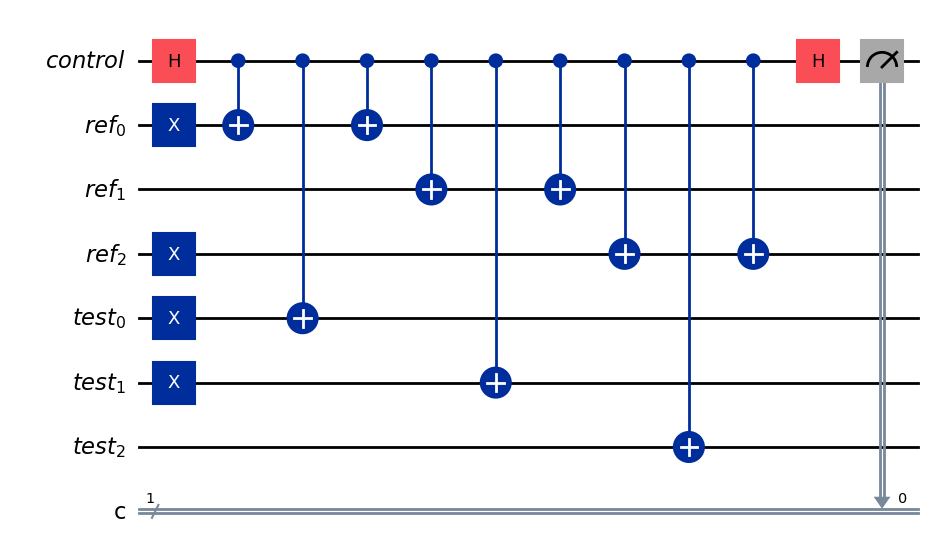

In [12]:
!pip install pylatexenc matplotlib --quiet

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
import math
from statistics import mean, stdev
import matplotlib.pyplot as plt
from IPython.display import display

# Utility: Random generator
rng = np.random.default_rng()
sim = AerSimulator()

# Preparation helpers
def prepare_basis_on(qc, reg, index):
    """Prepares a computational basis state |index> on given register."""
    bits = format(index, f'0{len(reg)}b')
    for i, bit in enumerate(reversed(bits)):
        if bit == '1':
            qc.x(reg[i])
    return bits

def prepare_uniform_plus_on(qc, reg):
    """Prepares uniform superposition |+++...> on given register."""
    qc.h(reg)
    return "+"

# Building SWAP test circuit
def swap_test_circuit(test_prep_fn):
    """
    Builds and returns SWAP test circuit + test_bits for given test_prep_fn.
    """
    # Define registers
    control = QuantumRegister(1, 'control')
    ref = QuantumRegister(3, 'ref')
    test = QuantumRegister(3, 'test')
    c = ClassicalRegister(1, 'c')

    qc = QuantumCircuit(control, ref, test, c)

    # Prepare reference state |101> (index=5)
    qc.x(ref[0])
    qc.x(ref[2])

    # Prepare test state using supplied function
    test_bits = test_prep_fn(qc, test)

    # SWAP test sequence
    qc.h(control[0])
    for i in range(3):
        qc.cx(control[0], ref[i])
        qc.cx(control[0], test[i])
        qc.cx(control[0], ref[i])
    qc.h(control[0])

    # Measure control qubit
    qc.measure(control[0], c[0])

    return qc, test_bits

# Experiment execution
def run_one(qc, shots, seed=None):
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots, seed_simulator=seed)
    res = job.result()
    counts = res.get_counts()
    p0 = counts.get('0', 0) / shots
    return p0, counts, tqc

def repeated_experiment(test_prep_fn, shots_list=[1000,2000,4000], repeats=30, test_label='test'):
    results = {}
    for s in shots_list:
        F_list = []
        for r in range(repeats):
            qc, test_bits = swap_test_circuit(test_prep_fn)
            p4, counts, tqc = run_one(qc, shots=s, seed=r+100)
            # Ensure p4 is in [0, 1]
            p4 = max(0.0, min(1.0, p4))
            F_hat = 2 * p4 - 1
            # Clip F_hat to [0, 1]
            F_hat = max(0.0, min(1.0, F_hat))
            F_list.append(F_hat)
        mu = mean(F_list)
        se = (stdev(F_list) / math.sqrt(len(F_list))) if len(F_list) > 1 else 0.0
        results[s] = {'mean_F': mu, 'stderr': se, 'raw': F_list}
    return results

def test_prep_same(qc, reg):
    return prepare_basis_on(qc, reg, reference_index)

def test_prep_diff(qc, reg):
    return prepare_basis_on(qc, reg, negative_index)

def test_prep_uniform(qc, reg):
    return prepare_uniform_plus_on(qc, reg)

# MEASUREMENT AND FIDELITY ESTIMATE
qc, test_bits = swap_test_circuit(test_prep_diff)
compiled = transpile(qc, sim)

# Simulation run at several shot values (1k, 2k, 4k)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
result1 = sim.run(compiled, shots=2000).result()
counts1 = result1.get_counts()
result2 = sim.run(compiled, shots=4000).result()
counts2 = result2.get_counts()

# Compute and display fidelity estimate
p0 = counts.get('0', 0) / 1000
fidelity_estimate = 2 * p0 - 1
p1 = counts1.get('0',0) / 2000
fidelity_estimate1 = 2 * p1 - 1
p2 = counts2.get('0',0)/4000
fidelity_estimate2 = 2 * p2 - 1

# Output
print(f"\nTest state bits: {test_bits}")
print(f"For 1000 shots")
print(f"P(output=1): {p0}")
print(f"Counts: {counts}")
print(f"Estimated fidelity: {fidelity_estimate:.3f}")
print(f"For 2000 shots")
print(f"P(output=1): {p1}")
print(f"Counts: {counts1}")
print(f"Estimated fidelity: {fidelity_estimate1:.3f}")
print(f"For 4000 shots")
print(f"P(output=1): {p2}")
print(f"Counts: {counts2}")
print(f"Estimated fidelity: {fidelity_estimate2:.3f}")

# Plot results for all 3 shot values
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# List of results
shot_counts = [1000, 2000, 4000]
counts_list = [counts, counts1, counts2]
fidelities = [fidelity_estimate, fidelity_estimate1, fidelity_estimate2]

for ax, shots, cts, fid in zip(axs, shot_counts, counts_list, fidelities):
    ax.bar(cts.keys(), cts.values(), color='royalblue')
    ax.set_title(f"{shots} shots\nFidelity ≈ {fid:.3f}")
    ax.set_xlabel("Measured Control Qubit")
    ax.set_ylabel("Counts")
    ax.set_ylim(0, max(cts.values()) * 1.2)
    ax.grid(axis='y', linestyle=':', alpha=0.6)

plt.suptitle("SWAP Test Results Across Different Shot Magnitudes", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# EVALUATION PROTOCOL
shots_list = [1000, 2000, 4000]
repeats = 30

print("\nRunning positive (same) trials...")
res_pos = repeated_experiment(test_prep_same, shots_list=shots_list, repeats=repeats, test_label='same')
print("Running negative (different) trials...")
res_neg = repeated_experiment(test_prep_diff, shots_list=shots_list, repeats=repeats, test_label='diff')
print("Running uniform superposition trials...")
res_uni = repeated_experiment(test_prep_uniform, shots_list=shots_list, repeats=repeats, test_label='uniform')

# Print evaluation results
print("\nShots | mean F (pos) ± stderr | mean F (neg) ± stderr")
for s in shots_list:
    mp = res_pos[s]['mean_F']; sp = res_pos[s]['stderr']
    mn = res_neg[s]['mean_F']; sn = res_neg[s]['stderr']
    print(f"{s:5d} | {mp:0.6f} ± {sp:0.6f} | {mn:0.6f} ± {sn:0.6f}")

# Sanity check for Identical States L=R
# Expected yield for mean F : 1
print("\nShots | mean F (uniform) ± stderr")
for s in shots_list:
    mu = res_uni[s]['mean_F']; su = res_uni[s]['stderr']
    print(f"{s:5d} | {mu:0.6f} ± {su:0.6f}")

# Sanity check for Different basis states (|000> cs |111>)
# Expected yield for mean F : ~0


# Draw circuit
fig = qc.draw("mpl")
display(fig)


How you distributed control:
- We used a single control qubit. This qubit controls all multi-qubit operations in the circuit.
- For each SWAP of qubits, where we have 3 pairs of register qubits (ref0, test0 ; ref1,test1 ; ref2, test2), we implemented SWAP through a sequence of three cx (CNOT) gates. This distributes the control from the single ancilla qubit to each pair of register qubits.
- We also used Hadamard gates on the control qubit for interference.

How many two‑qubit/three‑qubit gates we used:
For each of the three qubit pairs, we used three CNOTs.
Total CNOTs: 3 pairs × 3 CNOTs = 9 two-qubit gates.

Optimality:
We used only CNOT and Hadamard gates, which we note often reduces errors on real hardware.

How does the true fidelity differ from the estimated fidelity when we compare identical states? What is the effect of shot noise?:
- When comparing two identical quantum states, the true fidelity expected is exactly 1. In this case, across the three shot values (1k, 2k and 4k), the mean fidelity remains consistent at 1, with 0 standard deviation. Therefore, shot noise in this case appears insignificant. However, we note that due to finite number of shots, the observed probability P(0) is expected to fluctuate around its true value, leading to an estimated fidelity that is close to, but not always exactly 1.

How does the true fidelity differ from the estimated fidelity when we compare different states? What is the effect of shot noise?:
- When comparing tow differnt quantum states, the true fidelity is expected ot be less than 1. Due to shot noise, the estimate is likely slightly above or below the true value for any given run. This is highlighted by the standard deviations for each mean fidelity recorded.
- Shot noise introduces statistical uncertainty in the estimated, especially for smaller numbers of shots. This is reflected by our recorded standard deviations for the smaller 1k shots being larger than that of that for 2k shots and the standard deviations for 2k shots being larger than its that for the larger 4k shots.  




Assuming that the test state is in some unknown three-qubit computational basis state (while the reference state is still in the known state |5>), we will determine if the test state is in fact equal to the reference state by using the SWAP test.
We will
- prepare the reference state
- prepare the test state
- run the SWAP test circuit
- if the test state is identical to the reference, the control qubit will be measured as 0, and
- if different, the probability of measuring 0 drops.

Would you need to sample multiple times from the quantum circuit, or would a single sample suffice? Remember that we assume that only the reference state is known:
- A single measurement is not enough to reliably distinguish between identical and different states due to randomness and the probabilistic nature of measurement.
- Sampling multiple times allows for a better estimation of the probability of measuring 0 on the control qubit, and this a better determination of fidelity between states.
- As reflected by the experiment above, if th enumber of shots are smaller (and especially if states are more similar), there is a highly likelihood of stastistical error and therefore unreliabiltiy of the fidelity result obtained.

Based on the sample outcome(s), what would be your "decision rule" to determine if the test state is the same as the reference state or not?:
- My decision rule would be to run the SWAP circuit for at least 1000 or more shots, and compute the estimated fidelity with the formula provided in the assignment.
- Where measurements yield 0, I can be confident that the test state is the same as the reference state.
- However, keeping shot noise in mind, I will set a threshold for F, such that only if F is very close to 1, F willbe accepted as identical. If F is significantly less, the conclusion that the states are identical will be rejected.

## Task B.2 - Introducing superposition

In [14]:
def test_prep_superposed_left(qc, reg, index):
    qc.h(reg[0])
    bits = format(index, f'0{len(reg)}b')
    for i, bit in enumerate(reversed(bits[1:])):
        if bit == '1':
            qc.x(reg[i+1])
    return f"superposed_left_{index}"

def test_prep_superposed_left_pos(qc, reg):
    return test_prep_superposed_left(qc, reg, reference_index)

def test_prep_superposed_left_neg(qc, reg):
    return test_prep_superposed_left(qc, reg, negative_index)

print("\nRunning superposed left qubit (positive) trials...")
res_super_pos = repeated_experiment(test_prep_superposed_left_pos, shots_list=shots_list, repeats=repeats, test_label='superposed_pos')
print("Running superposed left qubit (negative) trials...")
res_super_neg = repeated_experiment(test_prep_superposed_left_neg, shots_list=shots_list, repeats=repeats, test_label='superposed_neg')

print("\nShots | mean F (superposed pos) ± stderr | mean F (superposed neg) ± stderr")
for s in shots_list:
    mp = res_super_pos[s]['mean_F']; sp = res_super_pos[s]['stderr']
    mn = res_super_neg[s]['mean_F']; sn = res_super_neg[s]['stderr']
    print(f"{s:5d} | {mp:0.6f} ± {sp:0.6f} | {mn:0.6f} ± {sn:0.6f}")



Running superposed left qubit (positive) trials...
Running superposed left qubit (negative) trials...

Shots | mean F (superposed pos) ± stderr | mean F (superposed neg) ± stderr
 1000 | 0.013600 ± 0.003134 | 0.013600 ± 0.003134
 2000 | 0.008367 ± 0.003311 | 0.008367 ± 0.003311
 4000 | 0.005067 ± 0.001880 | 0.005067 ± 0.001880


Do some negatives (k≠5) show larger fidelity? If yes, explain why. Relate to how fidelity encodes overlap: superposition spreads amplitude, increasing chance overlap with |5>.
- In our results above, both positive (k=5) and negative (K!=5) cases show identical fidelities. The standard deviation values also appear to overlap completely.
- However, we note that it is possible for some negatives to show a larger estimated fidelity.
- SWAP test fidelity quantifies the quantum state overlap as F=|<ref|test>|^2.
- With superposition, the test state is a quantum mixture of two basis states. This spreads amplitude such that for e.g. instead of comparing |101> to |011>, we are comparing |101> to a state that's half |x11> and half |y11>.
- If any half of the test state in superposition matches the reference, the observed fidelity can be larger for negatives.

Would it still be possible to determine if k=5 using the strategy you proposed in B.1? Explain why, or why not.
- Our experiment in B.1 shows the fidelities for both positive and negative cases as 0, with overlapping standard errors, indicating no clear spearation between positive and negative cases, suggesting that k=5 cannot be determined with high confidence, because the results do not distinguish between the two cases.

## Modifications based on feedback:



In [13]:
# Run SWAP test for k = 0 to 5 (test register basis state)
shots_list = [1000, 2000, 4000]
repeats = 30
results = {}

for k in range(6):  # k = 0,1,2,3,4,5
    def test_prep_superposed_left_k(qc, reg, k=k):
        qc.h(reg[0])  # Put leftmost qubit in superposition
        bits = format(k, f'0{len(reg)}b')
        for i, bit in enumerate(bits[1:]):
            if bit == '1':
                qc.x(reg[i+1])
        return bits

    def test_prep_fn(qc, reg, k=k):
        return test_prep_superposed_left_k(qc, reg, k)

    # Run repeated experiment for this k
    results[k] = repeated_experiment(lambda qc, reg: test_prep_fn(qc, reg, k), shots_list=shots_list, repeats=repeats, test_label=f'superposed_{k}')

# Print results for all k, with mean fidelity clipped to [0, 1]
print("\nShots | k | mean F ± stderr")
for s in shots_list:
    for k in range(6):
        mf = results[k][s]['mean_F']
        se = results[k][s]['stderr']
        # Clip mean fidelity to [0, 1]
        mf = max(0.0, min(1.0, mf))
        print(f"{s:5d} | {k:2d} | {mf:0.6f} ± {se:0.6f}")



Shots | k | mean F ± stderr
 1000 |  0 | 0.013600 ± 0.003134
 1000 |  1 | 0.013600 ± 0.003134
 1000 |  2 | 0.013600 ± 0.003134
 1000 |  3 | 0.013600 ± 0.003134
 1000 |  4 | 0.013600 ± 0.003134
 1000 |  5 | 0.013600 ± 0.003134
 2000 |  0 | 0.008367 ± 0.003311
 2000 |  1 | 0.008367 ± 0.003311
 2000 |  2 | 0.008367 ± 0.003311
 2000 |  3 | 0.008367 ± 0.003311
 2000 |  4 | 0.008367 ± 0.003311
 2000 |  5 | 0.008367 ± 0.003311
 4000 |  0 | 0.005067 ± 0.001880
 4000 |  1 | 0.005067 ± 0.001880
 4000 |  2 | 0.005067 ± 0.001880
 4000 |  3 | 0.005067 ± 0.001880
 4000 |  4 | 0.005067 ± 0.001880
 4000 |  5 | 0.005067 ± 0.001880


Your results on task B.2, when you are running the SWAP test, while putting one qubit in the test register in a superposition, are incorrect. You claim that both positives and negatives get a fidelity of 0, which is incorrect (you can also see my annotations in the PDF for further clarification).

In fact, you expect the fidelity of the positive case k = 5 to decrease from 1, but not go to zero. Why is this?
- When the test register is prepared in a superposition, the test state is no longer exactly the reference state e.g. ∣5⟩ on three qubits, but a quantum superposition of two basis states. If the test state were exactly
the reference state, the overlap would be 1.
- With a superposition, the overlap is shared between e.g. ∣5⟩ on three qubits, and another basis state, so the estimated fidelity decreases.
- The estimated fidelity does not go to zero as the test state still has a nonzero amplitude on e.g. ∣5⟩ on three qubits (modified superposition variant), so the overlap between the test state and reference state is nonzero, and therefore the SWAP test output should accordingly reflects this partial overlap, and should also not go to zero.

For one particular negative case k != 5 you expect to measure an increase in the fidelity. Why is this? And for what negative k do we see such an increase in the fidelity?
- When the test register is in a superposition, the overlap with the reference state depends on whether the superposition includes the reference state as one of its components:
- If the negative test state is a superposition that includes the reference state, the overlap with the reference increases, and so does the measured fidelity.

Reflection: what changed with superposition and one concrete improvement you would try next (e.g., alternate control distribution, or validating with exact inner products on the classical side).

Introducing superposition in the test state caused the SWAP test fidelity to lose its discriminative power, because the amplitude was now shared across multiple basis states, reducing overlap with the reference and making positive and negative cases nearly indistinguishable. An immediate improvement would be to validate quantum circuit results by calculating the exact inner product classically, which provides a reference for true state overlap and helps assess the circuit’s decision effectiveness under superposition.

# AI Assistance Disclosure

Generally, ChatGPT was used to guide us in the debugging of code.

**Per-Task Usage:**  
- **Task 1:** ChatGPT helped with the interpretation of the printed output.

Query: "this is what is printed: Bell state vector: [0.707107+0.j 0. +0.j 0. +0.j 0.707107+0.j]"

Answer: "Perfect ✅

Your printed result

[0.707107+0.j  0.      +0.j  0.      +0.j  0.707107+0.j]

is exactly the state vector... since the first entry corresponds to
∣00⟩, the last entry corresponds to ∣11⟩, and both have equal amplitude
1/√2.

So your implementation correctly produces the Bell state."

- **Task 2:**

Query: "what is the output bit"

Answer: "Good question — in the SWAP test, the output bit refers to the ancilla qubit (the extra qubit you add at the start of the circuit).

How it works:..."

- **Bonus:** ChatGPT was used to help refine the presentation of outputs of the experiments conducted.

**Validation:** AI outputs were tested in the notebook, adapted to match variable names and environment, and checked with documentation and sample data to ensure correctness.

